In [33]:
import h5py
import healpy as hp
import numpy as np
import os 
import yaml

import matplotlib
%matplotlib inline

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

import sys
sys.path.append('../code')
import utils
import run_inference
import plotter


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


../configs/configs_inference//config_inference_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.5_grid_nH020_nalphaagn20_noshuffle.yaml
../configs/configs_data/config_data_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.5.yaml
Loading likelihood grid from ../results/inference/inference_results_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.5_grid_nH020_nalphaagn20_noshuffle.h5
Loaded likelihood grid with shape: (20, 20)
H0 grid: 20 points from 50.0 to 100.0
alpha_agn grid: 20 points from 0.000 to 1.000


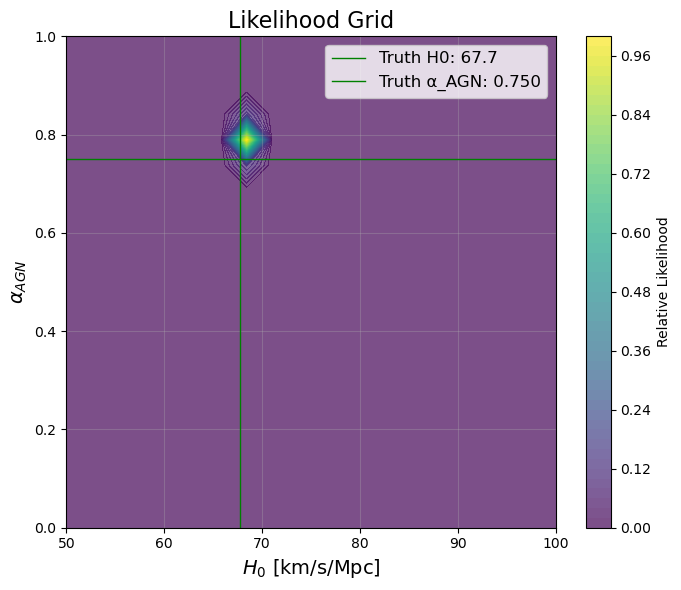

In [34]:
dir_configs = '../configs/configs_inference/'
fn_config_inference = f'{dir_configs}/config_inference_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.5_grid_nH020_nalphaagn20_noshuffle.yaml'
likelihood_data = plotter.get_likelihood_data(fn_config_inference)
plotter.plot_likelihood_data(likelihood_data)

../configs/configs_inference//config_inference_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn1.0_lambdaagn0.0_grid_nH030_nalphaagn30.yaml
../configs/configs_data/config_data_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn1.0_lambdaagn0.0.yaml
Loading likelihood grid from ../results/inference/inference_results_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn1.0_lambdaagn0.0_grid_nH030_nalphaagn30.h5
Loaded likelihood grid with shape: (30, 30)
H0 grid: 30 points from 50.0 to 100.0
alpha_agn grid: 30 points from 0.000 to 1.000


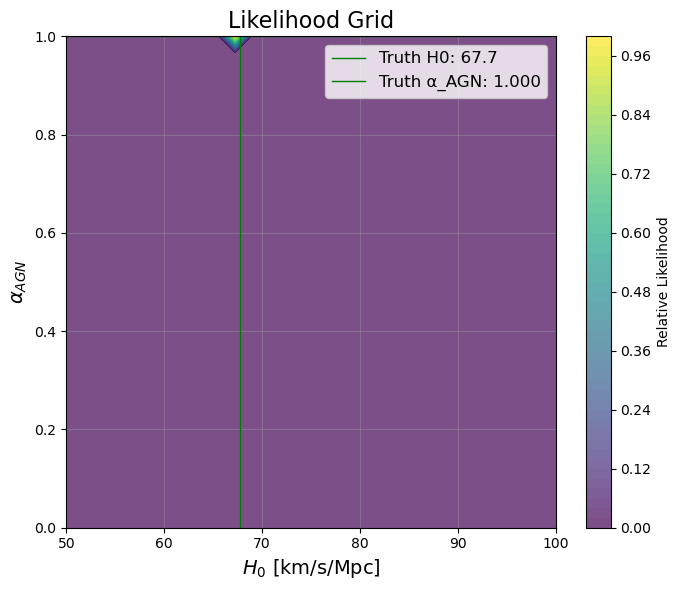

In [40]:
dir_configs = '../configs/configs_inference/'
fn_config_inference = f'{dir_configs}/config_inference_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn1.0_lambdaagn0.0_grid_nH030_nalphaagn30.yaml'
likelihood_data = plotter.get_likelihood_data(fn_config_inference)
plotter.plot_likelihood_data(likelihood_data)

../configs/configs_inference//config_inference_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0_grid_nH030_nalphaagn30.yaml
../configs/configs_data/config_data_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0.yaml
Loading likelihood grid from ../results/inference/inference_results_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0_grid_nH030_nalphaagn30.h5
Loaded likelihood grid with shape: (30, 30)
H0 grid: 30 points from 50.0 to 100.0
alpha_agn grid: 30 points from 0.000 to 1.000


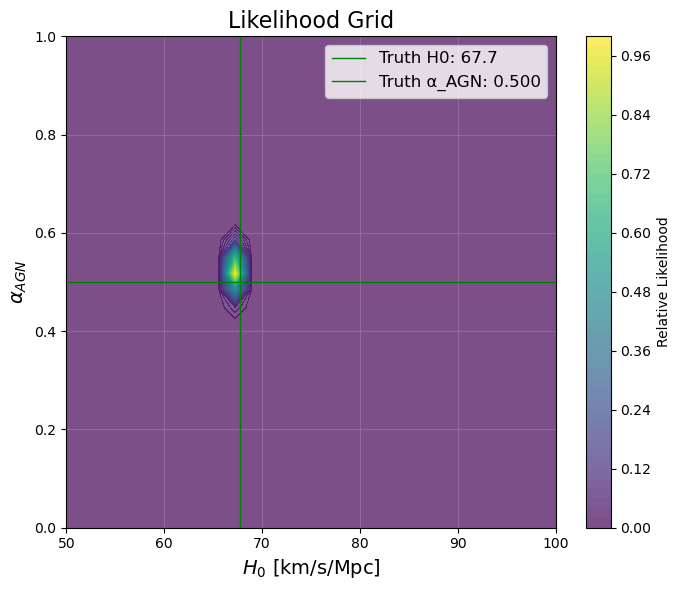

In [36]:
dir_configs = '../configs/configs_inference/'
fn_config_inference = f'{dir_configs}/config_inference_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0_grid_nH030_nalphaagn30.yaml'
likelihood_data = plotter.get_likelihood_data(fn_config_inference)
plotter.plot_likelihood_data(likelihood_data)

../configs/configs_inference//config_inference_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0_grid_nH030_nalphaagn30_norm.yaml
../configs/configs_data/config_data_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0.yaml
Loading likelihood grid from ../results/inference/inference_results_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0_grid_nH030_nalphaagn30_norm.h5
Loaded likelihood grid with shape: (30, 30)
H0 grid: 30 points from 50.0 to 100.0
alpha_agn grid: 30 points from 0.000 to 1.000


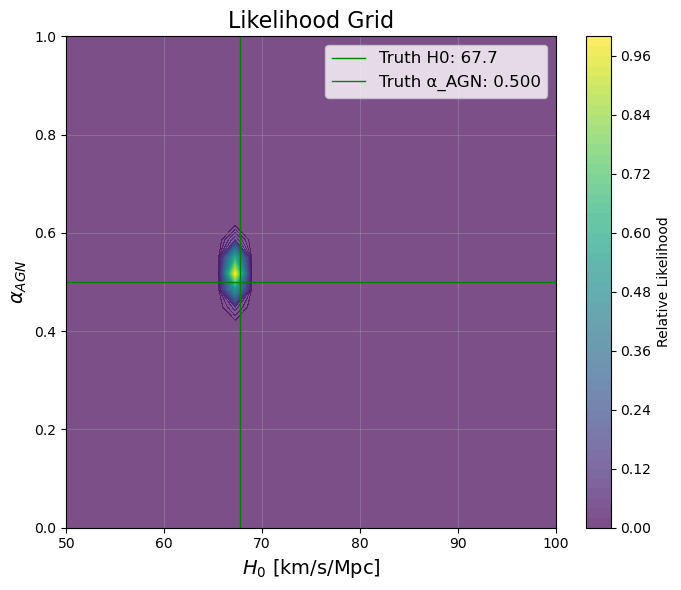

In [37]:
dir_configs = '../configs/configs_inference/'
tag_data = '_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0'
tag_inf = '_grid_nH030_nalphaagn30_norm'
fn_config_inference = f'{dir_configs}/config_inference{tag_data}{tag_inf}.yaml'
likelihood_data = plotter.get_likelihood_data(fn_config_inference)
plotter.plot_likelihood_data(likelihood_data)

../configs/configs_inference//config_inference_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0_grid_nH020_nalphaagn20_norm.yaml
../configs/configs_data/config_data_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0.yaml
Loading likelihood grid from ../results/inference/inference_results_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0_grid_nH020_nalphaagn20_norm.h5
Loaded likelihood grid with shape: (20, 20)
H0 grid: 20 points from 50.0 to 100.0
alpha_agn grid: 20 points from 0.000 to 1.000


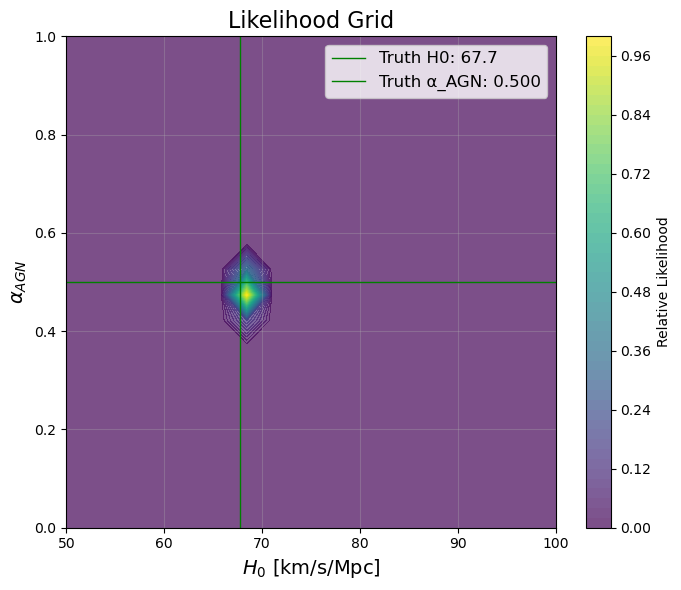

In [39]:
dir_configs = '../configs/configs_inference/'
tag_data = '_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0'
tag_inf = '_grid_nH020_nalphaagn20_norm'
fn_config_inference = f'{dir_configs}/config_inference{tag_data}{tag_inf}.yaml'
likelihood_data = plotter.get_likelihood_data(fn_config_inference)
plotter.plot_likelihood_data(likelihood_data)

../configs/configs_inference//config_inference_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0_grid_nH050_nalphaagn50.yaml
../configs/configs_data/config_data_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0.yaml
Loading likelihood grid from: ../results/inference/inference_results_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0_grid_nH050_nalphaagn50.h5
Loading likelihood grid from ../results/inference/inference_results_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0_grid_nH050_nalphaagn50.h5
Loaded likelihood grid with shape: (50, 50)
H0 grid: 50 points from 50.0 to 100.0
alpha_agn grid: 50 points from 0.000 to 1.000


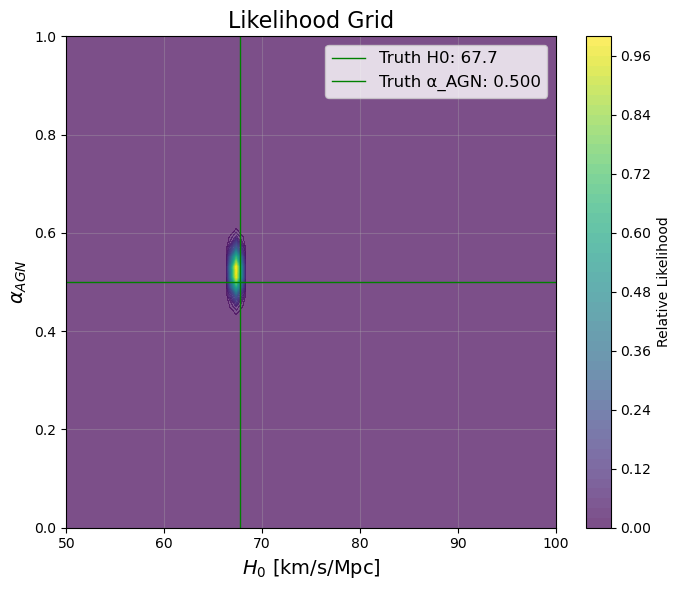

In [ ]:
dir_configs = '../configs/configs_inference/'
tag_data = '_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0'
tag_inf = '_grid_nH050_nalphaagn50'
fn_config_inference = f'{dir_configs}/config_inference{tag_data}{tag_inf}.yaml'
likelihood_data = plotter.get_likelihood_data(fn_config_inference)
plotter.plot_likelihood_data(likelihood_data)

../configs/configs_inference//config_inference_seed42_ratioNgalNagn10_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0_grid_nH030_nalphaagn30.yaml
../configs/configs_data/config_data_seed42_ratioNgalNagn10_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0.yaml
Loading likelihood grid from ../results/inference/inference_results_seed42_ratioNgalNagn10_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0_grid_nH030_nalphaagn30.h5
Loaded likelihood grid with shape: (30, 30)
H0 grid: 30 points from 50.0 to 100.0
alpha_agn grid: 30 points from 0.000 to 1.000
N_gal_truth: 1176983, N_agn_truth: 118148truth_f_agn: 0.5, truth_lambda_agn: 0.0
truth_alpha_agn: 0.5


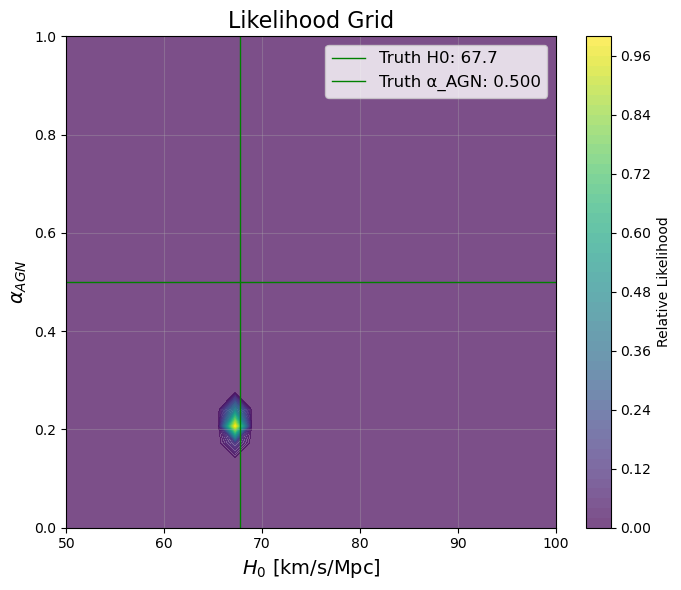

In [54]:
dir_configs = '../configs/configs_inference/'
tag_data = '_seed42_ratioNgalNagn10_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0'
tag_inf = '_grid_nH030_nalphaagn30'
fn_config_inference = f'{dir_configs}/config_inference{tag_data}{tag_inf}.yaml'
likelihood_data = plotter.get_likelihood_data(fn_config_inference)
plotter.plot_likelihood_data(likelihood_data)

../configs/configs_inference//config_inference_seed42_ratioNgalNagn10_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0_grid_nH030_nalphaagn30_norm.yaml
../configs/configs_data/config_data_seed42_ratioNgalNagn10_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0.yaml
Loading likelihood grid from ../results/inference/inference_results_seed42_ratioNgalNagn10_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0_grid_nH030_nalphaagn30_norm.h5
Loaded likelihood grid with shape: (30, 30)
H0 grid: 30 points from 50.0 to 100.0
alpha_agn grid: 30 points from 0.000 to 1.000


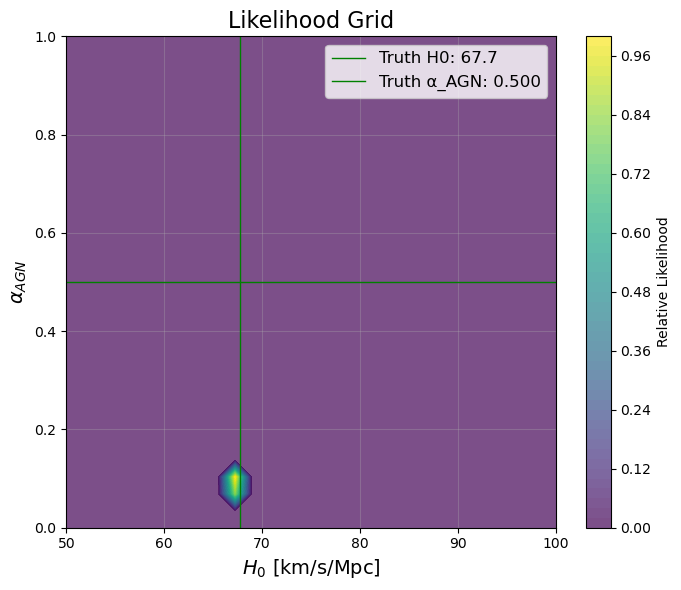

In [52]:
dir_configs = '../configs/configs_inference/'
tag_data = '_seed42_ratioNgalNagn10_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0'
tag_inf = '_grid_nH030_nalphaagn30_norm'
fn_config_inference = f'{dir_configs}/config_inference{tag_data}{tag_inf}.yaml'
likelihood_data = plotter.get_likelihood_data(fn_config_inference)
plotter.plot_likelihood_data(likelihood_data)

## Load and Plot MCMC Results

Load the MCMC results if available (for mcmc method).

In [45]:
dir_configs = '../configs/configs_inference/'
tag_data = '_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0'
tag_inf = '_mcmc_nw32_nsteps5000'
fn_config_inference = f'{dir_configs}/config_inference{tag_data}{tag_inf}.yaml'
print(fn_config_inference)

../configs/configs_inference//config_inference_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0_mcmc_nw32_nsteps5000.yaml


../configs/configs_inference//config_inference_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0_mcmc_nw32_nsteps5000.yaml
../configs/configs_data/config_data_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0.yaml
Loading MCMC results from: ../results/inference/inference_results_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0_mcmc_nw32_nsteps5000.h5
Loading inference results from ../results/inference/inference_results_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0_mcmc_nw32_nsteps5000.h5
<KeysViewHDF5 ['lower_bound', 'mcmc_chain', 'mcmc_log_prob', 'posterior_samples', 'upper_bound']>
Loaded MCMC results with shape: (128000, 2)
67.57555219138655 67.91498803400515
66.89979666947268 68.5941379143452
0.396780939495085 0.6458354054910345
0.3928131301001342 0.6522937595459448


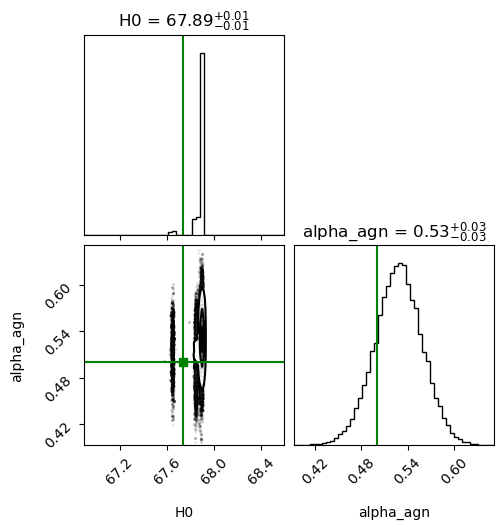

In [48]:
mcmc_data = plotter.get_mcmc_data(fn_config_inference)
plotter.plot_mcmc_contours(mcmc_data)

In [49]:
dir_configs = '../configs/configs_inference/'
tag_data = '_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.5'
tag_inf = '_mcmc_nw32_nsteps5000'
fn_config_inference = f'{dir_configs}/config_inference{tag_data}{tag_inf}.yaml'
print(fn_config_inference)

../configs/configs_inference//config_inference_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.5_mcmc_nw32_nsteps5000.yaml


../configs/configs_inference//config_inference_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.5_mcmc_nw32_nsteps5000.yaml
../configs/configs_data/config_data_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.5.yaml
Loading MCMC results from: ../results/inference/inference_results_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.5_mcmc_nw32_nsteps5000.h5
Loading inference results from ../results/inference/inference_results_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.5_mcmc_nw32_nsteps5000.h5
<KeysViewHDF5 ['lower_bound', 'mcmc_chain', 'mcmc_log_prob', 'posterior_samples', 'upper_bound']>
Loaded MCMC results with shape: (128000, 2)
67.61384202502852 67.8663458194978
66.93770360477824 68.54500927769277
0.7115153901507455 0.9199096314030991
0.7044002362492381 0.9291087277171302


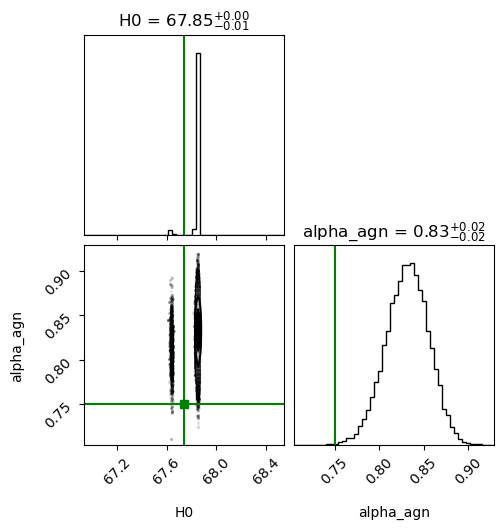

In [50]:
mcmc_data = plotter.get_mcmc_data(fn_config_inference)
plotter.plot_mcmc_contours(mcmc_data)